<a href="https://colab.research.google.com/github/Hernan4444/INF3842-2024-1/blob/main/Codigos/Clase_4_Visualizaciones_Tabulares_Matplotlib_Seaborn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Visualizaciones con [Pandas](https://pandas.pydata.org/), [Matplotlib](https://matplotlib.org/) y [Seaborn](https://seaborn.pydata.org/)

En el siguiente práctico se registra todos los códigos para los gráficos presentados en clases.

Trabajaremos con un dataset sobre enfermedades cardiacas: https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction

# Pasos previos

1. Vamos a importar las librerías necesarias para este práctico
2. Vamos a definir una función que permite descargar los datasets necesarios para construir los gráficos desde _google drive_.

In [ ]:
import pandas as pd
import requests
import seaborn as sns
import matplotlib.pyplot as plt

def download_file_without_authenticate(id, destination):
    def get_confirm_token(response):
        for key, value in response.cookies.items():
            if key.startswith("download_warning"):
                return value

    URL = "https://docs.google.com/uc?export=download"
    response = requests.get(URL, params={"id": id, "confirm": 1}, stream=True)

    CHUNK_SIZE = 32768
    with open(destination, "wb") as f:
        for i, chunk in enumerate(response.iter_content(CHUNK_SIZE)):
            if chunk:  # filter out keep-alive new chunks
                f.write(chunk)

    return None

In [ ]:
# Descargar archivo
download_file_without_authenticate("10tJScI6sQeczony0ToWjw0EUpoeSBvpa", "Heart Failure Prediction Dataset.csv")

In [ ]:
# Utilizar la función read_csv para cargar el archivo
df = pd.read_csv("Heart Failure Prediction Dataset.csv")

# Ver las primeras 5 líneas del archivo
df.head(5)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


## Sección express ML

Vamos a entrenar 3 modelos y predecir su información con estos.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC


# Separar características y etiquetas
X = df.drop('HeartDisease', axis=1)
y = df['HeartDisease']

# Identificar columnas numéricas y categóricas
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X.select_dtypes(include=['object']).columns

# Preprocesamiento
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(), categorical_cols)
    ])

# Dividir el dataset en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.4,
                                                    stratify=y)

# Modelos
models = {
    'LogisticR': LogisticRegression(),
    'RandomF': RandomForestClassifier(),
    'SVM': SVC()
}

for model_name, model in models.items():
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('model', model)])
    pipeline.fit(X_train, y_train)
    df[model_name + '_prediction'] = pipeline.predict(X)

df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease,LogisticR_prediction,RandomF_prediction,SVM_prediction
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0,0,0,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1,0,1,0
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0,0,0,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1,1,1,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0,0,0,0


# Gráfico de barra

Haremos un gráfico para comparar el rendimiento de los 3 modelos.

In [ ]:
from sklearn.metrics import accuracy_score

modelos = df.columns[df.columns.str.contains('_prediction')]
data = []
for m in modelos:
    name = m.strip("_prediction")
    score = accuracy_score(df['HeartDisease'], df[m])
    data.append([name, score])

df_modelos = pd.DataFrame(data, columns=['Modelo', 'Accuracy'])
df_modelos

,Modelo,Accuracy
0,LogisticR,0.868192
1,RandomF,0.949891
2,SVM,0.903050


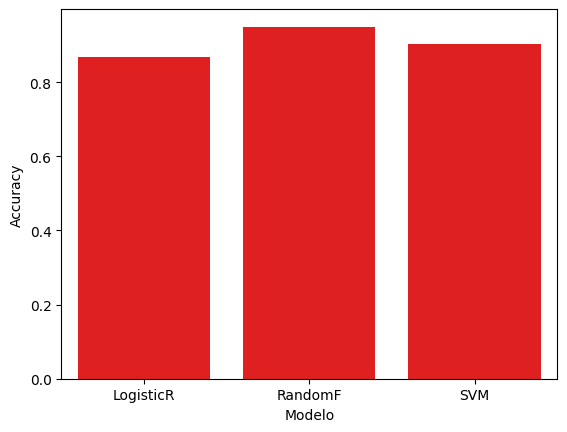

In [ ]:
ax = sns.barplot(x="Modelo", y="Accuracy", data=df_modelos, color="red")
plt.show()

Si intercambiamos los ejes (x e y), hacemos un gráfico de barra horizontal. Tambien podemos indicar el nombre de los ejes y el título

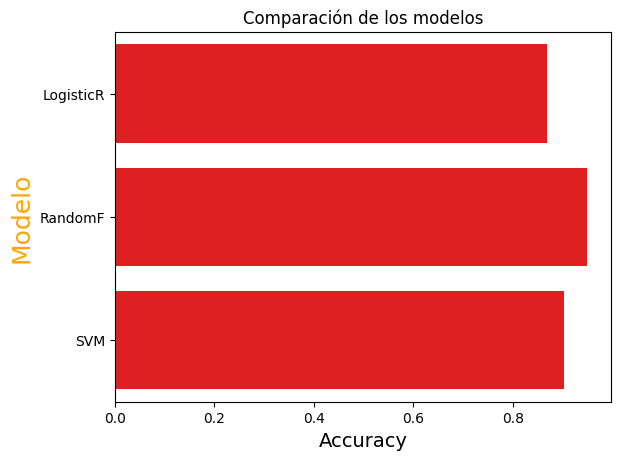

In [ ]:
ax = sns.barplot(x="Accuracy", y="Modelo", data=df_modelos, color="red")
ax.set_xlabel("Accuracy", fontdict={"fontsize": 14})
ax.set_ylabel("Modelo", fontdict={"fontsize": 18, "color": "orange"})
ax.set_title('Comparación de los modelos')
plt.show()

## Ver valor en barras

Para ver el valor en las barras. Desde la versión 3.4 de matplotlib se agregó una nueva función llamada `bar_label` para poder incluir el valor de las barras.

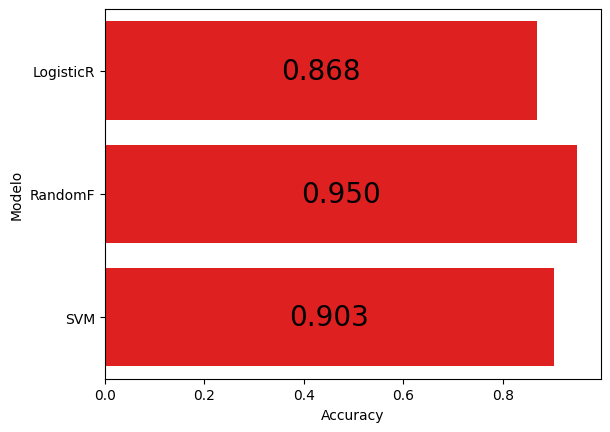

In [ ]:
ax = sns.barplot(x="Accuracy", y="Modelo", data=df_modelos, color="red")

# fmt='%.3f' -> 3 decimales
ax.bar_label(ax.containers[0], fmt='%.3f', label_type="center",
             padding=0, fontsize=20)

plt.show()

## Dejar a seaborn la agregación de información

Si quisieramos ver, por ejemplo, la edad promedio de la muestra de datos por género. Podemos usar `pandas`, o bien podemos dejar que `seaborn` haga la agrupación.

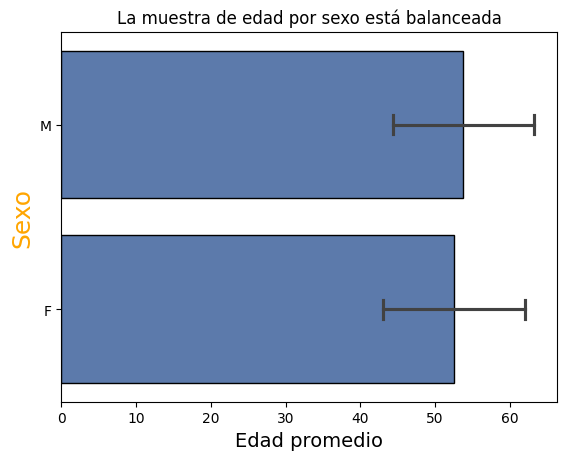

In [ ]:
ax = sns.barplot(y="Sex", x="Age", data=df, # Le damos el dataset original
                 # Definir orden de las barras
                 order=["M", "F"],
                 # Indicar que saque el promedio. Tambien se podría poner "sum" o "count"
                 estimator="mean",
                 # Agregar sd para desviación estandar. Tambien puede ser ci para intervalos de confianza
                 errorbar="sd",
                 # Poner límites en la barra de la desviación
                 capsize=0.1,
                 # Color de la barra
                 color="#4f77b8",
                 # Color de los bordes
                 edgecolor="black"
                 )

ax.set_xlabel("Edad promedio", fontdict={"fontsize": 14})
ax.set_ylabel("Sexo", fontdict={"fontsize": 18, "color": "orange"})
ax.set_title('La muestra de edad por sexo está balanceada')
plt.show()

# Gráfico de línea

Para poder graficar una sola serie de datos (una observacion en cada momento) vamos a elegir a un sexo. En este caso a las mujeres.

In [ ]:
mujeres = df[df.Sex == 'F']
mujeres.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease,LogisticR_prediction,RandomF_prediction,SVM_prediction
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1,0,1,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1,1,1,1
6,45,F,ATA,130,237,0,Normal,170,N,0.0,Up,0,0,0,0
9,48,F,ATA,120,284,0,Normal,120,N,0.0,Up,0,0,0,0
10,37,F,NAP,130,211,0,Normal,142,N,0.0,Up,0,0,0,0


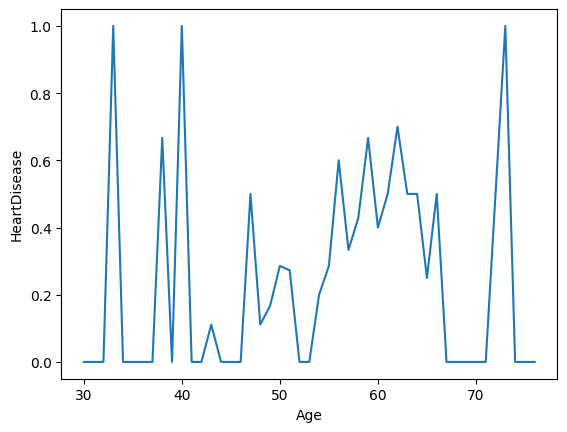

In [ ]:
ax = sns.lineplot(x="Age", y="HeartDisease", data=mujeres,
                  errorbar=None, estimator="mean")
plt.show()

Tambien podemos hacer gráfico de múltiples líneas llamando varias veces a `sns.lineplot`

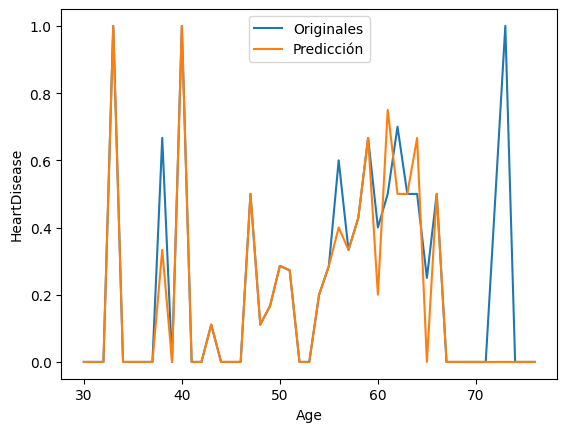

In [ ]:
ax = sns.lineplot(x="Age", y="HeartDisease", data=mujeres,
                  estimator="mean", errorbar=None, label="Originales")

ax = sns.lineplot(x="Age", y="RandomF_prediction", data=mujeres,
                  estimator="mean", errorbar=None, label="Predicción")

# Si hacemos multilenea de forma manual, nosotros activamos la leyenda
plt.legend()
plt.show()

O bien, usando el parámetro `hue` y la columna que determina dicha categoría.

In [ ]:
df_melted = mujeres.melt(id_vars='Age',
                    value_vars=['RandomF_prediction', 'HeartDisease'],
                    var_name='Columna', value_name='Valor')

df_melted.sample(10)

,Age,Columna,Valor
180,71,RandomF_prediction,0
98,63,RandomF_prediction,1
245,41,HeartDisease,0
157,62,RandomF_prediction,1
320,50,HeartDisease,0
373,71,HeartDisease,0
112,41,RandomF_prediction,0
28,49,RandomF_prediction,0
294,54,HeartDisease,0
99,57,RandomF_prediction,0


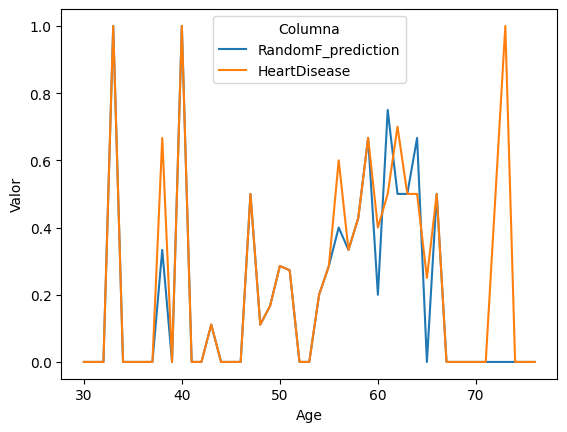

In [ ]:
ax = sns.lineplot(x="Age", y="Valor", hue="Columna", data=df_melted,
                  estimator="mean", errorbar=None)

plt.show()

Tambien podemos definir parámetros sobre la línea

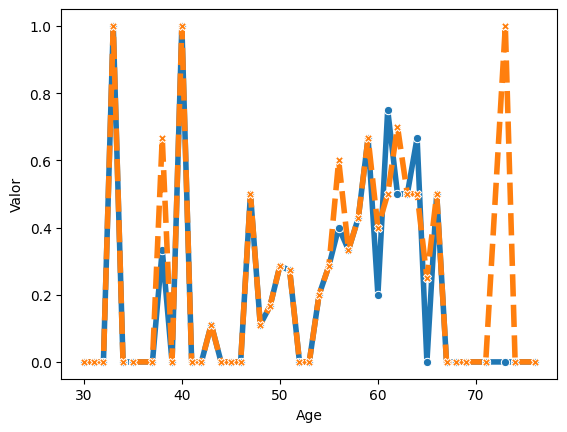

In [ ]:
ax = sns.lineplot(x="Age", y="Valor", hue="Columna", data=df_melted,
                  estimator="mean", errorbar=None,
                  # Ancho de línea
                  lw=4,
                  # Usar lineas punteadas
                  dashes=True,
                  # Tipo de línea punteada según valor de alguna columna
                  style="Columna",
                  # Incluir puntos en cada dato
                  markers=True,
                  # Incluir o no la leyenda
                  legend=False,
                  )

# Gráfico de dispersión

Haremos un gráfico de dispersión donde:
* **El eje X** codifica la edad
* **El eje Y** codifica la máxima frecuencia cardiaca

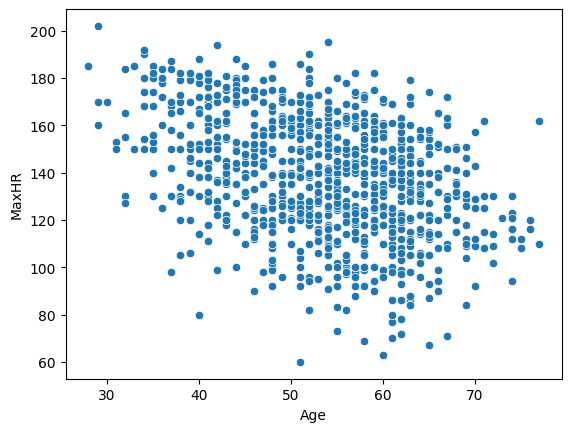

In [ ]:
ax = sns.scatterplot(x="Age", y="MaxHR", data=df)
plt.show()

Podemos codificar varios atributos simulteneamente con un _bubblechart_ en Seaborn. Solo debemos utilizar más parámetros en la función de `scatterplot`.

* `size="Cholesterol"` es para que el tamaño de los puntos está en función del nivel de colesterol.
* `hue="Sex"` es para que el color ("hue") de los puntos está en función del sexo de la persona (F o M).
* `sizes=(20,250)`es para indica en rango de tamaños para el círculo más pequeño y más grande. Se recomienda experimentar con este parámetro porque no se indica si aquellos números representan pixeles, milimetros, pulgadas, etc. Por lo tanto se debe probar para ver cómo resulta el gráfico.
* `palette="Set2"` es para indicar qué paleta de colores utilizar. Visitar https://matplotlib.org/stable/tutorials/colors/colormaps.html para ver las paletas de colores.
* `legend=False` para eliminar la leyenda.


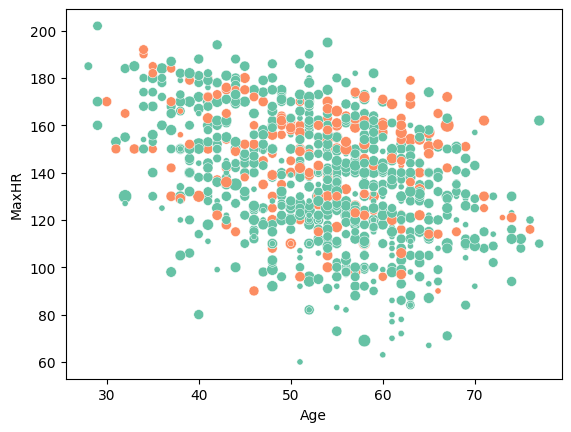

In [ ]:
ax = sns.scatterplot(x="Age", y="MaxHR", hue="Sex", size="Cholesterol",
                     sizes=(20, 100), palette='Set2', data=df, legend=False)
plt.show()

Ahora dejaremos una leyenda

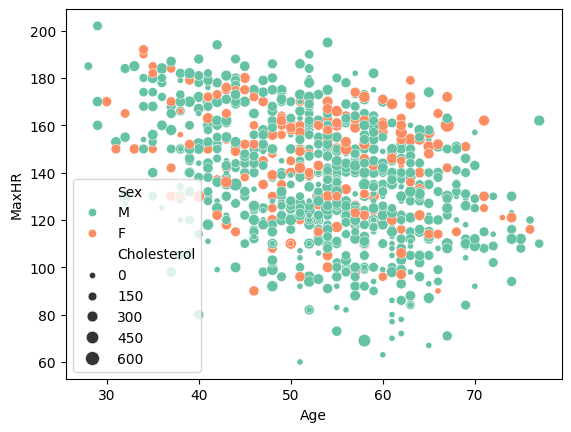

In [ ]:
ax = sns.scatterplot(x="Age", y="MaxHR", hue="Sex", size="Cholesterol",
                     sizes=(20, 100), palette='Set2', data=df, legend="auto")
plt.show()

# Histograma

Visualizaremos la distribución de la variable age con un histograma

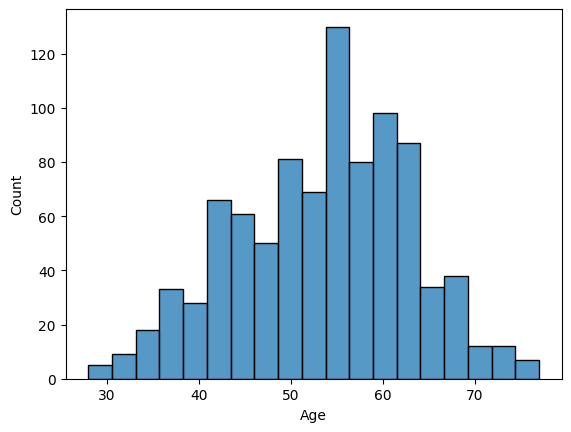

In [ ]:
ax = sns.histplot(df.Age)
plt.show()

Podemos porsonalizar los _bins_

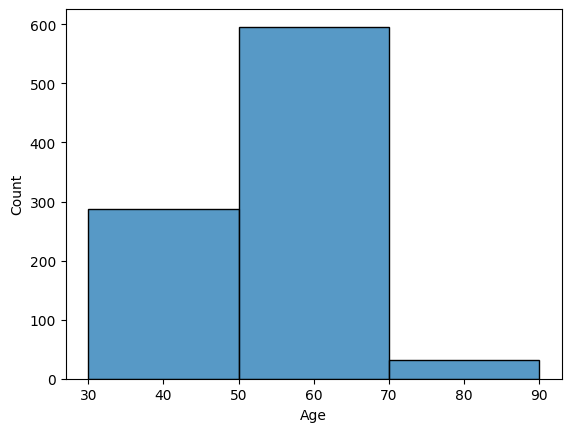

In [ ]:
ax = sns.histplot(df.Age, bins=[30, 50, 70, 90])
plt.show()

Tal vez queremos ver la curva de probabilidad. Para esto usamos el atributo `kde=True`. Además queremos ver 2 distribuciones simulteneamente, así que llamamos 2 veces a `sns.histplot` y a cada una le definimos un `label` para que cuando hagamos `plt.legend()`, matplotlib sepa como se llama cada color en la leyenda.

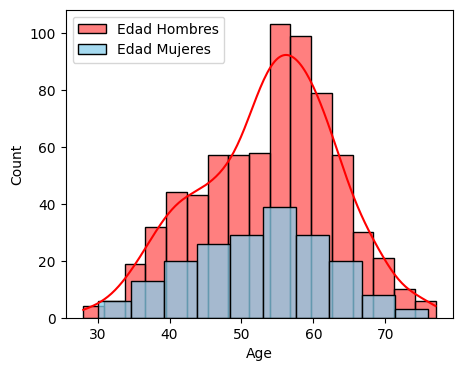

In [ ]:
sns.histplot(df.Age[df.Sex=="M"], kde=True, color="red",
             label="Edad Hombres")

sns.histplot(df.Age[df.Sex=="F"], kde=False, color="skyblue",
             label="Edad Mujeres")


plt.legend()
plt.show()

# Gráfico de Caja

Visualizaremos la distribución de la variable edad con un gráfico de caja.

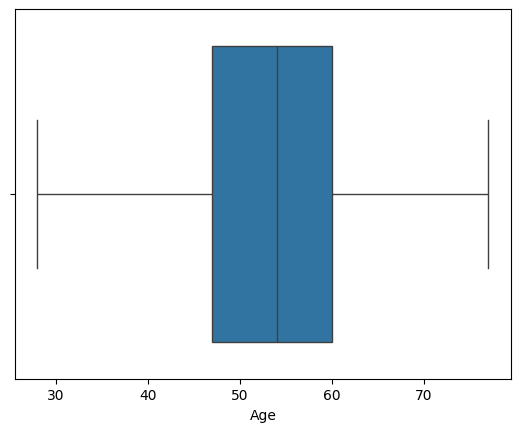

In [ ]:
ax = sns.boxplot(x=df.Age)
plt.show()

para forzar que quede horizontal solo cambiamos el `x` por `y`. Luego, para cambiar el color se usan el argumento `color="red"`.

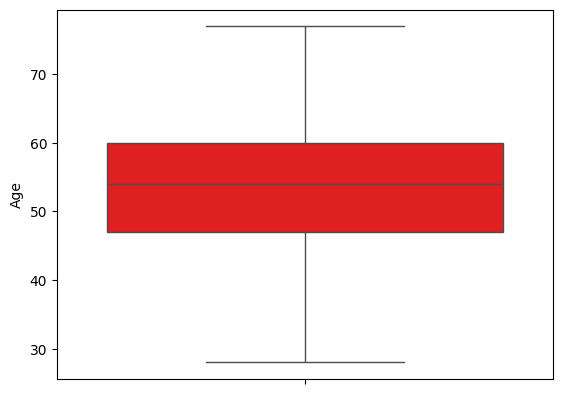

In [ ]:
ax = sns.boxplot(y=df.Age, color="red")
plt.show()

Ahora veamos la distribución de edad según la predicción realizada y el sexo.

La orientación del gráfico (horizontal o vertical) se ajustará según el eje donde indiquemos la columna con **datos cuantitativos**.


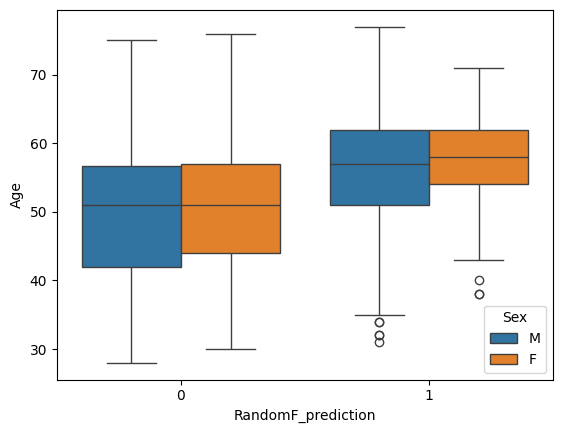

In [ ]:
ax = sns.boxplot(x="RandomF_prediction", y="Age", data=df, hue="Sex")
plt.show()

Podemos agregar más personalizaciones.

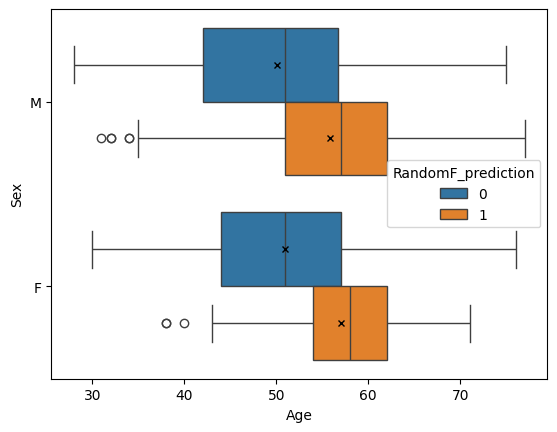

In [ ]:
meanprops={"marker":"x", "markerfacecolor":"white",
           "markeredgecolor":"black","markersize":"5"}

ax = sns.boxplot(x="Age", y="Sex", data=df, hue="RandomF_prediction",
                 showmeans=True, meanprops=meanprops)
plt.show()

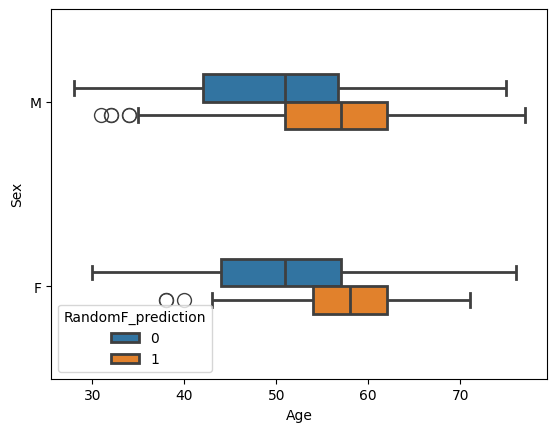

In [ ]:
ax = sns.boxplot(y="Sex",
                 x="Age",
                 data=df,
                 hue="RandomF_prediction",
                 width=0.3,
                 #### Otros parámetros
                 fliersize=10, # 0 si queremos eliminar los outlier
                 linewidth=2,
                 # Espacio entre la caja y el extremo de la línea. Lo normal es 1.5
                 whis=1.5,
                 )

# Gráfico de Violín



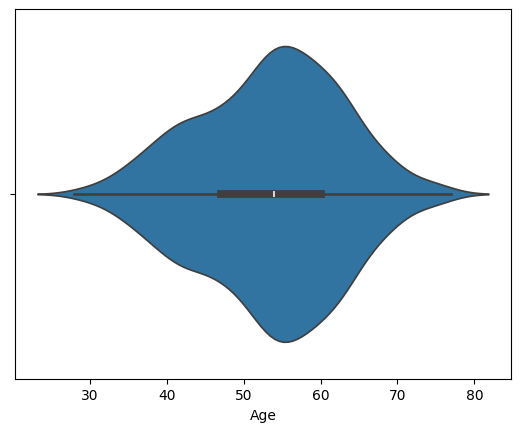

In [ ]:
ax = sns.violinplot(x=df.Age)
plt.show()

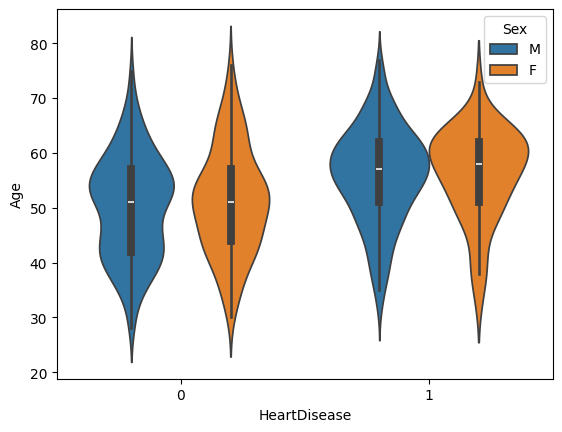

In [ ]:
ax = sns.violinplot(x="HeartDisease", y="Age", data=df, hue="Sex")
plt.show()

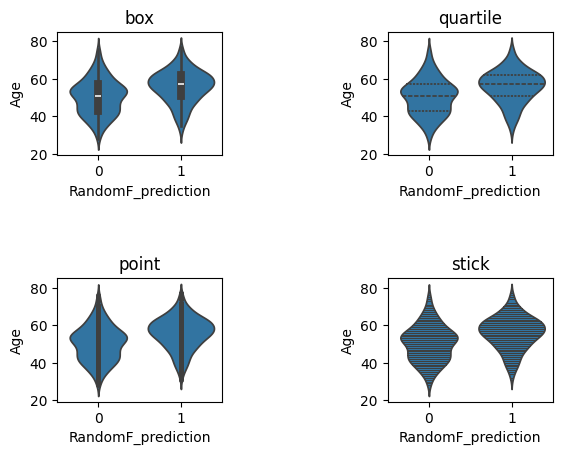

In [ ]:
fig, axs = plt.subplots(2, 2)
options = ["box", "quartile", "point", "stick"]
axis = [axs[0][0], axs[0][1], axs[1][0], axs[1][1]]

i = 0
for option in options:
    sns.violinplot(y="Age", x="RandomF_prediction", data=df,
                   inner=options[i], ax=axis[i])
    axis[i].set_title(options[i])
    i+= 1

plt.subplots_adjust(hspace=1, wspace=1)
plt.show()

# Gráfico de Torta

Primero agrupamos por una columna y contamos cuantos datos por valor distinto de dicha columna hay.

In [ ]:
new_df = df.groupby("Sex").size()
new_df.head()

Sex
F    193
M    725
dtype: int64

Se crea un gráfico de torta con el método `pie` y se le entrega la lista de valores.

Esta función retorna una lista con los diferentes objetos presentes en la visualización. Lo importante es el  primer elemento de la lista que corresponde a cada segmento circular. En este caso, son 2 segmentos (1 por sexo).

Luego se agrega la leyenda. Para esto se usa `plt.legend` y se le entrega la lista de cada segmento circular y una lista de _strings_ que será el nombre asignado a cada elemento. Además le podemos dar un título a la leyenda.


Finalmente se asigna un título al gráfico.


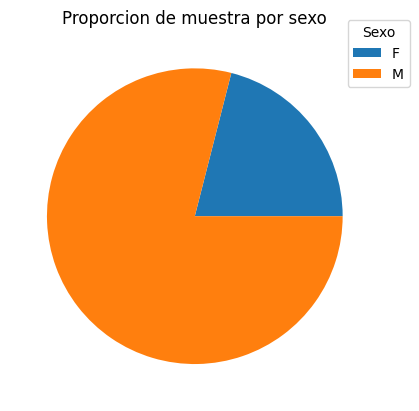

In [ ]:
# bbox_to_anchor permite mover la legenda de posición
pie_plot = plt.pie(new_df)
plt.legend(pie_plot[0], new_df.index, title="Sexo",
           bbox_to_anchor=(1.1, 1.05))
plt.title("Proporcion de muestra por sexo")
plt.show()

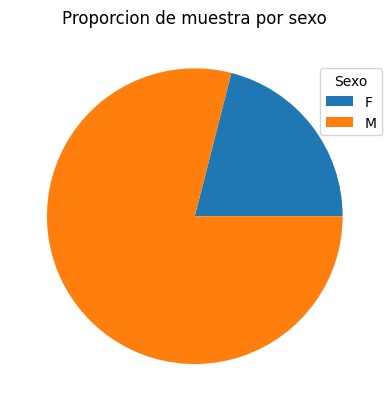

In [ ]:
# bbox_to_anchor permite mover la legenda de posición
pie_plot = plt.pie(new_df)
plt.legend(pie_plot[0], new_df.index, title="Sexo",
           bbox_to_anchor=(0.82, 0.7))
plt.title("Proporcion de muestra por sexo")
plt.show()

También podemos personalizar más el gráfico de torta

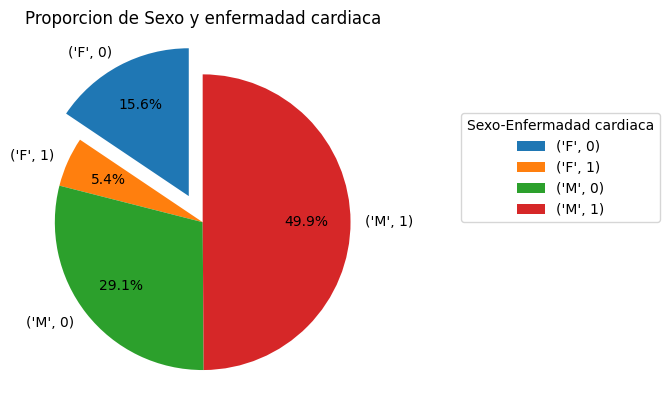

In [ ]:
new_df = df.groupby(["Sex", "HeartDisease"]).size()

pie_plot = plt.pie(new_df,
                   labels=new_df.index,
                   autopct='%1.1f%%', # Ver texto
                   explode=[0.2, 0, 0, 0], # Angulo de salida de cada sector
                   startangle=90, # Angulo de inicio
                   pctdistance=0.7, # Distancia del texto (porcentaje) con el centro
                   radius=1 # Tamaño
                   )

plt.legend(pie_plot[0], new_df.index,
           title="Sexo-Enfermadad cardiaca",
           loc=(1.2, 0.5)) # Con Loc uno puede jugar con la posición de la legenda

#Se asigna un título al gráfico
plt.title("Proporcion de Sexo y enfermadad cardiaca", pad=10)

plt.show()

# Mapa de calor

Usamos la función `groupby` y `pivot` para indexar el dataset en un formato matríz

In [ ]:
df_groupby = df.groupby(["HeartDisease", "RandomF_prediction"],
                        as_index=False).size()
df_groupby.head()

,HeartDisease,RandomF_prediction,size
0,0,0,384
1,0,1,26
2,1,0,18
3,1,1,490


In [ ]:
df_pivot = df_groupby.pivot(index="HeartDisease", columns="RandomF_prediction",
                            values="size")
df_pivot.head()

RandomF_prediction,0,1
HeartDisease,,
0,384,26
1,18,490


[`sns.heatmap`](https://seaborn.pydata.org/generated/seaborn.heatmap.html) recibe el _dataset_ indexado y crea inmediatamente el _heatmap_.


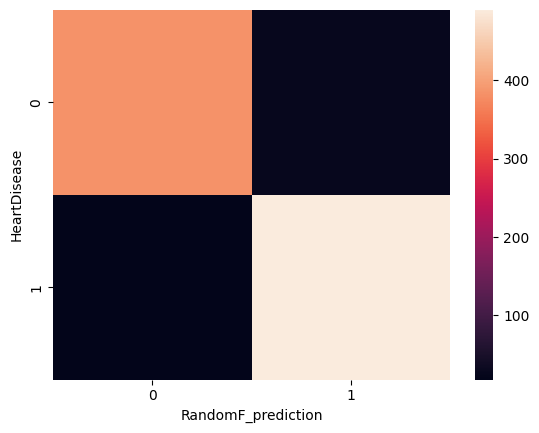

In [ ]:
ax = sns.heatmap(df_pivot)
plt.show()

El tamaño de este gráfico lo podemos personalizar indicando el tamaño de la figura a matplotlib con `plt.rcParams['figure.figsize']`.

Luego, podemos personalizar nuestro _heatmap_ con diferentes argumentos:

- `annot=True`: específica si se escribe o no el valor en la celda.
- `fmt="d"`: específica el formato de escritura del valor (d para valores enteros).
- `annot_kws={'size:10'}`: específica argumentos para el texto de las anotaciones, como el tamaño.
- `cmap='coolwarm'`: para la secuencia de colores. En este caso la paleta es `coolwarm` que es una paleta divergente.
- `linewidths=.5`: para marcar espaciado entre las celdas.
- `center=200` para indicar el centro de la divergencia **solo si se ocupa una paleta divergente**. [Aquí](https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html) puede encontrar información de las paletas disponibles.


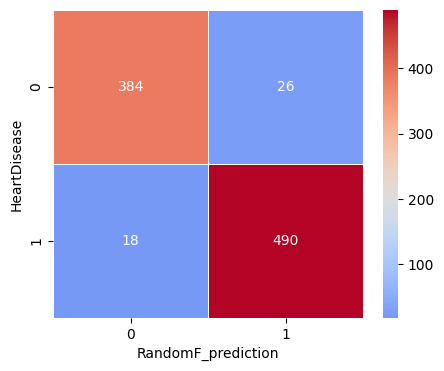

In [ ]:
plt.rcParams['figure.figsize'] = (5.0, 4.0)  # Ancho, altura en pulgadas.

ax = sns.heatmap(df_pivot, annot=True, fmt="d", annot_kws={'size':10},
                 cmap='coolwarm',
                 linewidths=.5, center=200)
plt.show()

En vez de agrupar y pivotear, podemos usar `confusion_matrix` para facilitar el proceso.

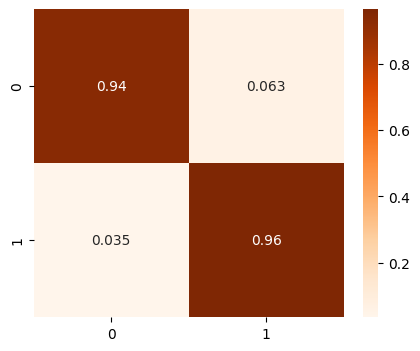

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(df.HeartDisease, df.RandomF_prediction, normalize="true")

sns.heatmap(cm, annot=True, cmap="Oranges")
plt.show()

# Matriz de Gráficos

In [ ]:
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease,LogisticR_prediction,RandomF_prediction,SVM_prediction
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0,0,0,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1,0,0,0
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0,0,0,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1,1,1,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0,0,0,0


Con [`FacetGrid`](https://seaborn.pydata.org/generated/seaborn.FacetGrid.html) se crea la matriz y específica sus dimensiones a partir del _dataset_.
- `col="sex"` para que en las columnas iran los valores del atributo `sex`.
- `row="HeartDisease"` para que en las filas iras los valores del atributo `HeartDisease`.

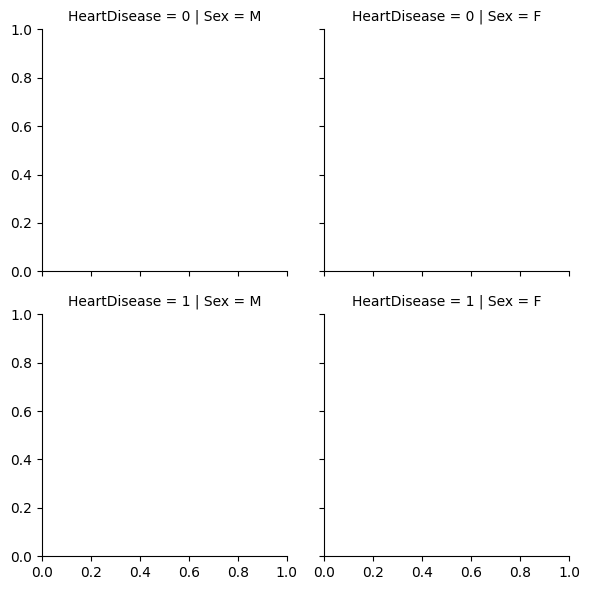

In [ ]:
g = sns.FacetGrid(df, col="Sex", row="HeartDisease")
plt.show()

Ahora vamos a llegar cada espacio de la grilla. Para eso uamos el método `map`. Primero le debemos indicar la función que permie generar el gráfico, en este caso `plt.scatter`.

El resto de los argumentos corresponden a los atributos propios del gráficos de dispersión correspondiente `total_bill` en el **eje X**, y `tip` en el **eje Y**.


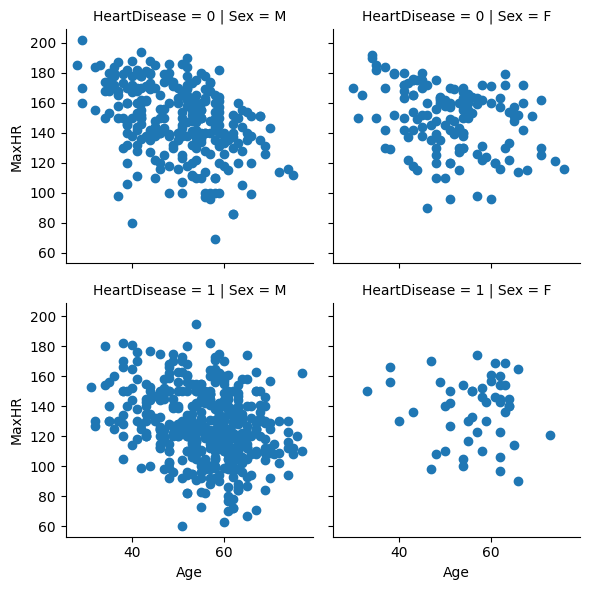

In [ ]:
g = sns.FacetGrid(df, col="Sex", row="HeartDisease")
g.map(plt.scatter, "Age", "MaxHR")
plt.show()

Tambien existen otras formas de hacer matrices de gráfico. Por ejemplo con [`sns.lmplot`](https://seaborn.pydata.org/generated/seaborn.lmplot.html). En este caso:
- `x="Age` e `y="MaxHR"` para indicar qué atributos se usarán en cada eje.
- `col="HeartDisease"` y `row="Sex"` se ocupan a igual que en FacetGrid para indicar como dividir los datos en filas y columnas.
- `data=df` es para indicar de donde provienen los datos.

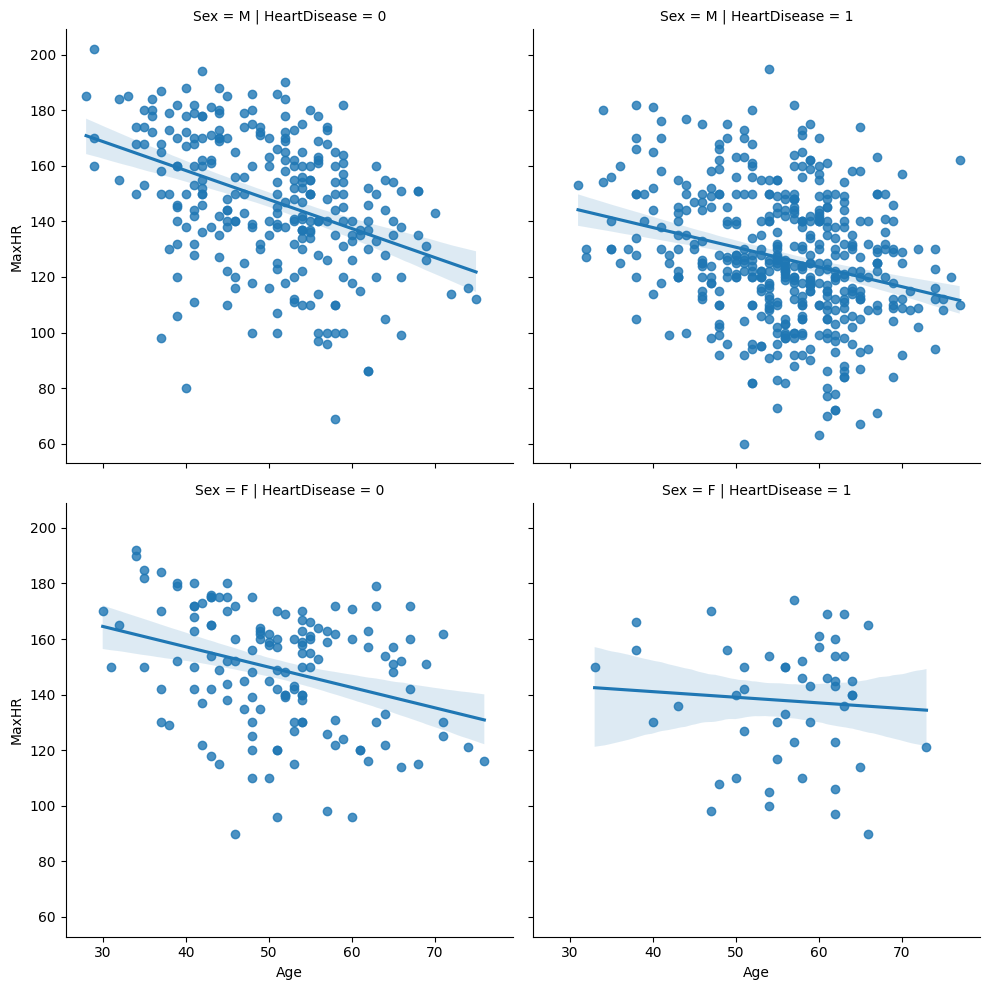

In [ ]:
g = sns.lmplot(x="Age", y="MaxHR", col="HeartDisease", row="Sex", data=df)
plt.show()

Tambien podemos usar [`sns.pairplot`](https://seaborn.pydata.org/generated/seaborn.pairplot.html) para hacer una matriz donde cada gráfico es una combinación distinta de pares de atributos numéricos. Además usamos `height=1.5` para hacer gráficos pequeños.

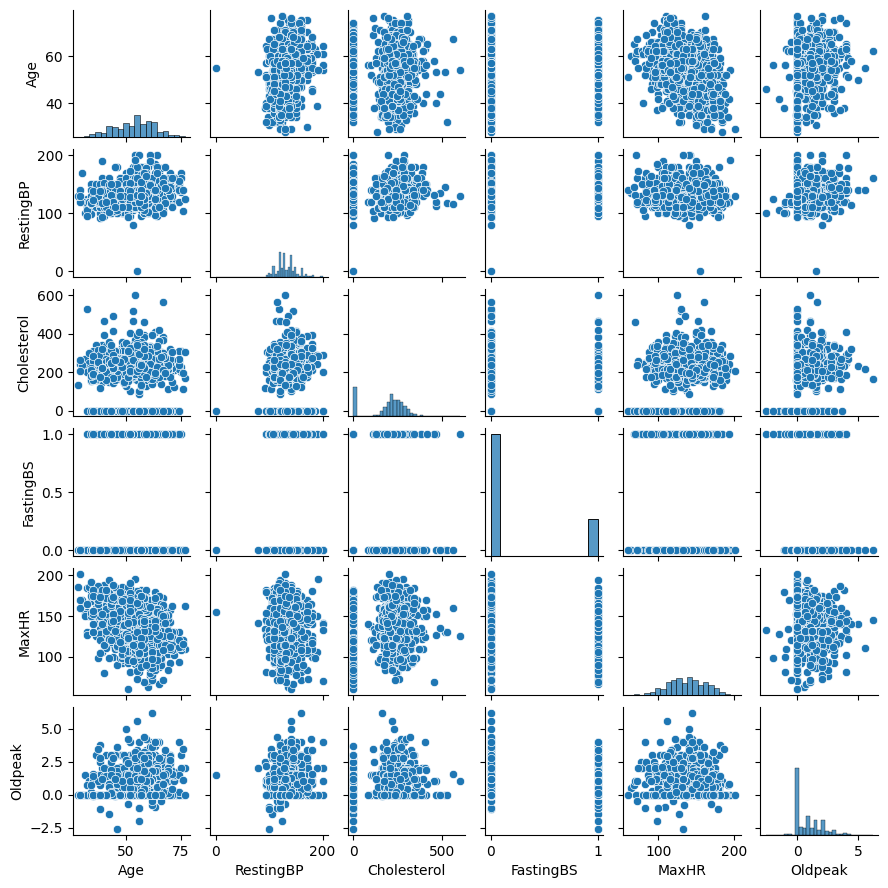

In [ ]:
original_column = ["Age", "Sex", "ChestPainType", "RestingBP", "Cholesterol", "FastingBS",
                   "RestingECG", "MaxHR", "ExerciseAngina", "Oldpeak", "ST_Slope"]

g = sns.pairplot(df[original_column], height=1.5)
plt.show()

Como la matriz generalmente es simetrica, podemos ahorrarnos una mitad con el parámetro `corner` y personalizar más codificación usando tonalidad de color (`hue`) y cambio de paleta (`palette`)

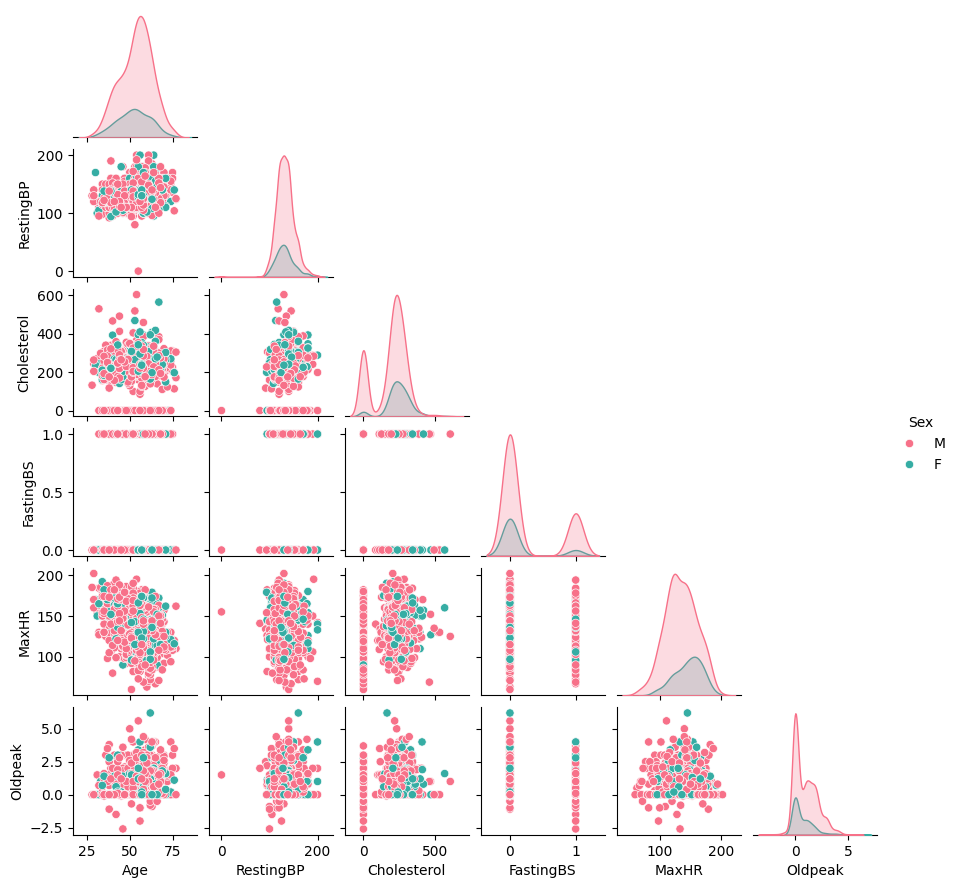

In [ ]:
g = sns.pairplot(df[original_column], hue="Sex", palette="husl",
                 corner=True, height=1.5)
plt.show()

Tal vez no se requiere ver todas las combinaciones de variables. Se pueden específicar en `x_vars` e `y_vars` las variables a cruzar.

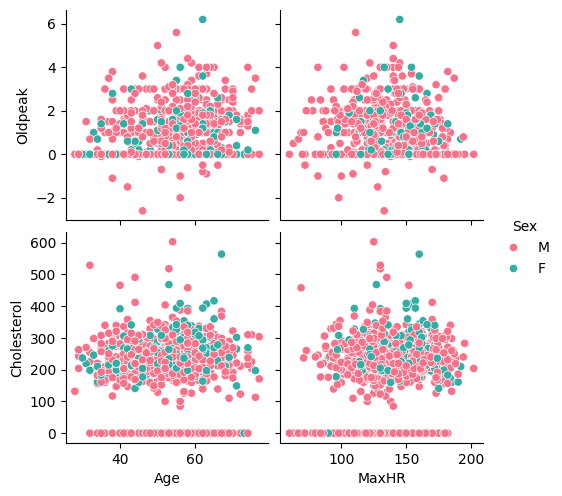

In [ ]:
g = sns.pairplot(df, hue="Sex", palette="husl",
                 x_vars=["Age", "MaxHR"],
                 y_vars=["Oldpeak", "Cholesterol"])
plt.show()

Podemos definir qué tipo de visualización será la diagonal y el tipo de los demás gráficos.

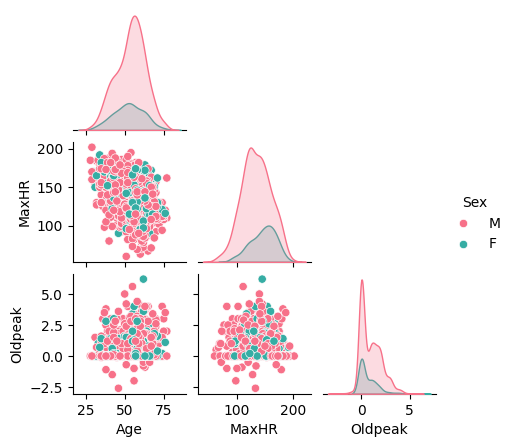

In [ ]:
g = sns.pairplot(df[["Age", "MaxHR", "Oldpeak", "Sex"]], hue="Sex",
                 palette="husl", diag_kind="kde", corner=True,
                 height=1.5, kind="scatter")
plt.show()

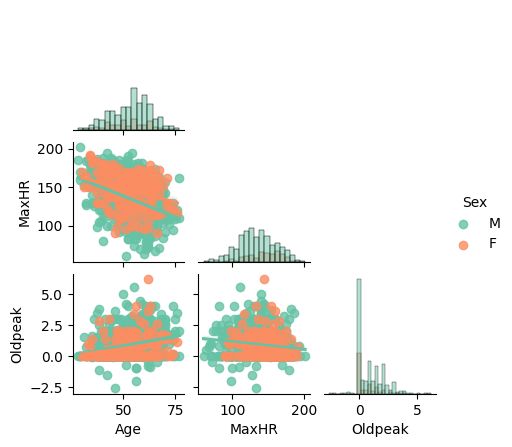

In [ ]:
g = sns.pairplot(df[["Age", "MaxHR", "Oldpeak", "Sex"]], hue="Sex",
                 palette="Set2", diag_kind="hist", corner=True,
                 height=1.5, kind="reg")
plt.show()

# Pequeños Multiples

Para hacer esta visualización, pimero generamos una grilla en donde los argumentos son:
- `data=df`: indicar de donde provienen los datos.
- `col="ChestPainType"`: indicar qué columna utilizar para definir cuantos gráficos hay.
- `hue="ChestPainType"`: indicar qué columna utilizar para definir los colores de cada gráfico.
- `col_wrap=2`: indicar cuantas columnas pueden haber.

Importante recordar que esta función solo genera los gráficos sin datos, ahora falta indicar con qué llenar cada gráfico. Para esto usamos el método `map` cuyos argumentos son:

- `plt.scatter`: indicar la forma con la que se llenará cada gráfico.  Para este curso, puede ser `plt.plot` para gráfico de línea o `plt.scatter` para gráfico de dispersión.
- `"Age"`: indicar qué columna utilizar como coordenada en el eje X.
- `"RestingBP"`: indicar qué columna utilizar como coordenada en el eje Y.


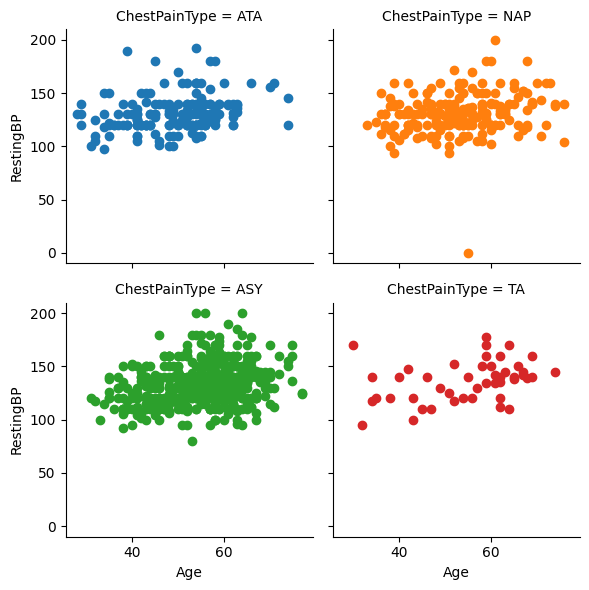

In [ ]:
grid = sns.FacetGrid(data=df, col="ChestPainType", hue="ChestPainType", col_wrap=2)
grid.map(plt.scatter, "Age", "RestingBP")
plt.show()

Ahora vamos a ver la cantidad de personas con enfermedades cardiacas según su edad y segmentados por _"ChestPainType"_. Su significado es:
* TA: Typical Angina
* ATA: Atypical Angina
* NAP: Non-Anginal Pain
* ASY: Asymptomatic

Primero vamos a preparar los datos para calcular esa cantidad de personas. Luego hacer la `FacetGrid` y finalmente llenarlo de gráficos de líneas.

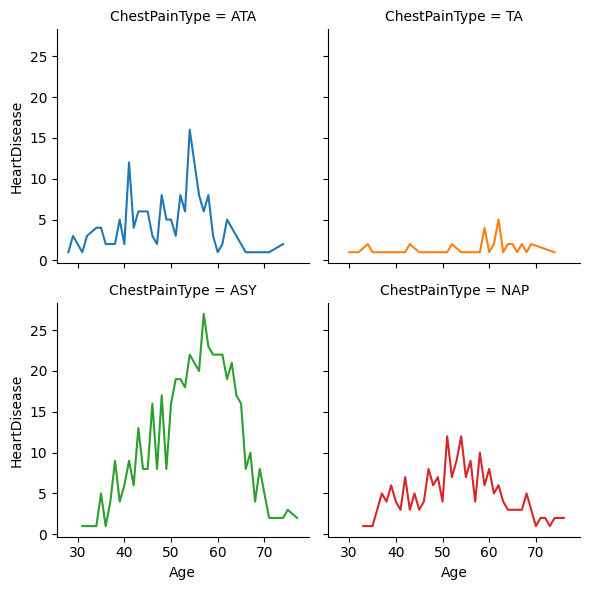

In [ ]:
df_grouped = df.groupby(["Age", "ChestPainType"], as_index=False).HeartDisease.count()

grid = sns.FacetGrid(data=df_grouped, col="ChestPainType", hue="ChestPainType",
                     col_wrap=2)

grid.map(plt.plot, "Age", "HeartDisease")
plt.show()

Seaborn tiene otra forma rápida de crear _small multiple_ con `relplot` (así no usamos `grid` y `map`): https://seaborn.pydata.org/generated/seaborn.relplot.html#seaborn.relplot

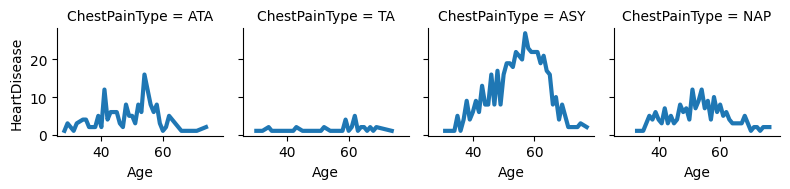

In [ ]:
df_grouped = df.groupby(["Age", "ChestPainType"], as_index=False).HeartDisease.count()


ax = sns.relplot(x="Age",
                 y="HeartDisease",
                 data=df_grouped,
                 lw=3,
                 dashes=True,
                 markers=True,
                 legend=True,
                 # 3 argumentos que necesita relplot
                 col_wrap=4,
                 kind="line",
                 col="ChestPainType",
                 # Extras
                 height=2
                 )

## _Small múltiple_ de multiínea

¿Y si necesito varias líneas por gráfico?. Primero vamos a obtener la cantidad de personas con enfermedad cardiacas según los 3 modelos.

In [ ]:
import random

df_grouped = df.groupby(["Age", "Sex"], as_index=False).sum()
df_grouped = df_grouped[["Age", "Sex", "HeartDisease", "LogisticR_prediction",
                         "RandomF_prediction", "SVM_prediction"]]
df_grouped.head()

,Age,Sex,HeartDisease,LogisticR_prediction,RandomF_prediction,SVM_prediction
0,28,M,0,0,0,0
1,29,M,0,0,0,0
2,30,F,0,0,0,0
3,31,F,0,0,0,0
4,31,M,1,1,1,1


Luego usamos la función [`melt`](https://pandas.pydata.org/docs/reference/api/pandas.melt.html) de pandas para convertir el _dataset_ en un formato donde tengamos únicamente 1 columna numérica.

In [ ]:
df_convertido = df_grouped.melt(id_vars=["Age", "Sex"], value_name="Count",
                                var_name="HeartResult")
df_convertido.sample(10)

,Age,Sex,HeartResult,Count
226,52,F,RandomF_prediction,0
135,52,F,LogisticR_prediction,1
148,58,M,LogisticR_prediction,23
203,40,M,RandomF_prediction,5
297,42,F,SVM_prediction,0
105,37,F,LogisticR_prediction,0
201,39,M,RandomF_prediction,3
125,47,F,LogisticR_prediction,1
280,33,F,SVM_prediction,1
323,55,F,SVM_prediction,2


Ahora solo basta usar el parámetro `hue="column"` para indicar a Seaborn qué columna del _dataset_ utilizar para segmentar las líneas y definir los colores. Adicionalmente agregamos 2 parámetros más:
- `height=3` para indicar la atura, en pulgadas, de cada gráfico.
- `aspect=1.5` para indicar la relación de aspecto de cada gráfico. De este modo, `aspect * height` nos dará el ancho, el pulgadas, de cada gráfico.

Cómo ahora tendremos varias líneas, incluimos `grid.add_legend()` para agregar la leyenda en la visualización.


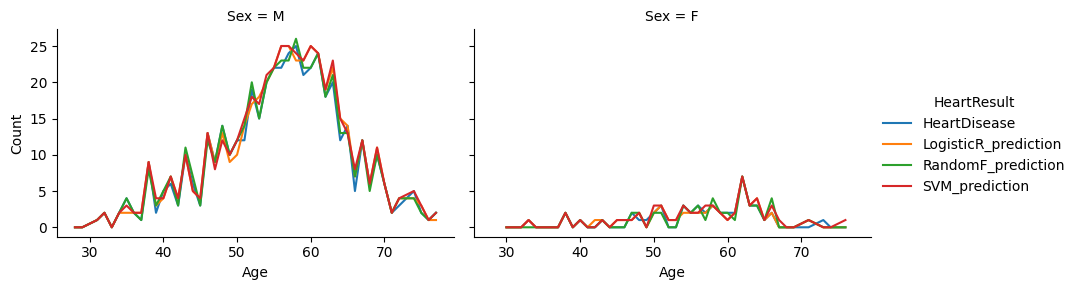

In [ ]:
grid = sns.FacetGrid(data=df_convertido, col="Sex", hue="HeartResult",
                     col_wrap=2, height=3, aspect=1.5)

grid.map(plt.plot, "Age", "Count")
grid.add_legend()

plt.show()

Y podemos hacer lo mismo con `relplot`

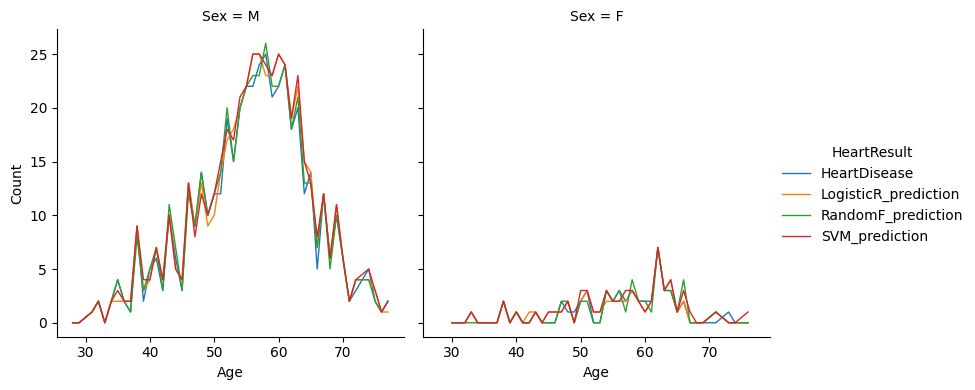

In [ ]:
ax = sns.relplot(x="Age",
                 y="Count",
                 data=df_convertido,
                 hue="HeartResult",
                 lw=1,
                 legend=True,
                 col_wrap=2,
                 kind="line",
                 col="Sex",
                 # un argumento opcional para definir tamaño
                 height=4)

# Bonus


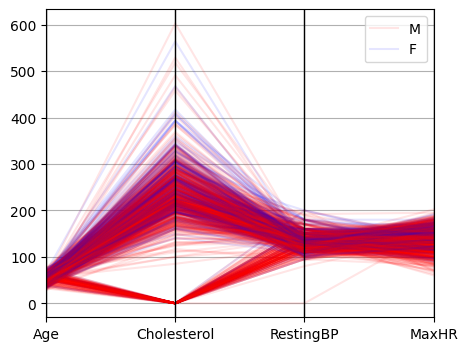

In [ ]:
pd.plotting.parallel_coordinates(df, class_column='Sex', color=["red", "blue"],
                                 cols=["Age", "Cholesterol", "RestingBP", "MaxHR"],
                                 alpha=0.1)
plt.show()

# ¿Eso es todo?

**No**. A continuación dejamos links que podrían ser útiles para descubrir más tipos de gráficos y su posible implementación en código:

- Pandas Visualization (https://pandas.pydata.org/pandas-docs/stable/user_guide/visualization.html): Lista de gráficos que provee la librería pandas.

- Seaborn Examples (https://seaborn.pydata.org/examples/index.html): Ejemplos de gráficos realizados con seaborn, junto a su código.

- Matplotlib Gallery (https://matplotlib.org/stable/gallery/index.html): Galería de ejemplos de gráficos realizados en matplotlib, junto a su código.

- Dataviz Project (https://datavizproject.com/): Catálogo de diferentes tipos de visualizaciones, junto a su explicación de para qué sirven y algunos ejemplos.

- Python Graph Gallery (https://www.python-graph-gallery.com): Catálogo de diferentes tipos de visualizaciones, junto a una breve explicación y código para realizarlos (ojo que algunos pueden estar programados en librerías de python no vistas en el curso).

Adicionalmente, existen muchas librerías que no se vieron en el curso. Algunas son:

- Plotly (https://plotly.com/python/).
- Bokeh (https://docs.bokeh.org/en/latest/docs/gallery.html).
- Yellowbrick (https://www.scikit-yb.org/en/latest/gallery.html).


¿Y solo Python? ¿no hay más?  Si, hay librerías para muchos lenguajes más. Si desean hacer páginas web, tal vez necesitaran librerías para Javascript como:

- D3.js (https://observablehq.com/@d3/gallery).
- AnyChart.js (https://www.anychart.com/).